In [1]:
# Cell 1: Imports
import matplotlib.pyplot as plt
import pandas as pd
import lightning.pytorch as pl
import mlflow
import torch
from pathlib import Path

import numpy as np

# PyTorch Forecasting specific imports
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models.temporal_fusion_transformer import (
    TemporalFusionTransformer,
)
from pytorch_forecasting.metrics import QuantileLoss

from utils.config_reader import get_config
# Standard logging and utility imports (MOCK/SIMULATED)
import logging
import os
import yaml

/Users/rezaghasemi/Documents/github/ts_mini_project/.venv/lib/python3.10/site-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
train_raw_data = pd.read_csv("data/airline_passengers/train_data.csv")
test_raw_data = pd.read_csv("data/airline_passengers/test_data.csv")    

In [3]:
train_raw_data.head()

,Date,Year,Month,Passengers
0,1949-01-01,1949,1,97
1,1949-02-01,1949,2,97
2,1949-03-01,1949,3,109
3,1949-04-01,1949,4,127
4,1949-05-01,1949,5,158


In [4]:
config = get_config("src/config/config.yaml")

[2025-11-26 17:45:46] utils.config_reader INFO Config file src/config/config.yaml loaded


In [5]:
history_length = config["TFT_model"]["history_length"]
prediction_length = config["TFT_model"]["prediction_length"]

all_data = pd.concat([train_raw_data, test_raw_data], ignore_index=True)
train_raw_data["time_idx"] = range(len(train_raw_data))
train_raw_data["group_id"] = 0
test_raw_data["group_id"] = 0
test_raw_data["time_idx"] = range(len(test_raw_data))
all_data["time_idx"] = range(len(all_data))
all_data["group_id"] = 0

train_DataSet = TimeSeriesDataSet(
    train_raw_data,
    group_ids=["group_id"],
    target="Passengers",
    time_idx="time_idx",
    min_encoder_length=history_length,
    max_encoder_length=history_length,
    max_prediction_length=prediction_length,
    time_varying_known_reals=["Month", "Year"],
    time_varying_unknown_reals=["Passengers"],
)

test_DataSet = TimeSeriesDataSet(
    test_raw_data,
    group_ids=["group_id"],
    target="Passengers",
    time_idx="time_idx",
    min_encoder_length=history_length,
    max_encoder_length=history_length,
    max_prediction_length=prediction_length,
    time_varying_known_reals=["Month", "Year"],
    time_varying_unknown_reals=["Passengers"],
)



In [6]:
all_data.describe()

,Year,Month,Passengers,time_idx,group_id
count,144.000000,144.000000,144.000000,144.000000,144.0
mean,1954.500000,6.500000,284.145833,71.500000,0.0
std,3.464102,3.464102,156.815511,41.713307,0.0
min,1949.000000,1.000000,52.000000,0.000000,0.0
25%,1951.750000,3.750000,159.500000,35.750000,0.0
50%,1954.500000,6.500000,255.000000,71.500000,0.0
75%,1957.250000,9.250000,381.250000,107.250000,0.0
max,1960.000000,12.000000,709.000000,143.000000,0.0


In [7]:
all_DataSet = TimeSeriesDataSet(
    all_data,
    group_ids=["group_id"],
    target="Passengers",
    time_idx="time_idx",
    min_encoder_length=history_length,
    max_encoder_length=history_length,
    max_prediction_length=prediction_length,
    time_varying_known_reals=["Month", "Year"],
    time_varying_unknown_reals=["Passengers"],
)

In [8]:
train_raw_data.shape, test_raw_data.shape, all_data.shape

((120, 6), (24, 6), (144, 6))

In [9]:
model = TemporalFusionTransformer.from_dataset(
            train_DataSet,
            learning_rate=config["TFT_model"]["learning_rate"],
            hidden_size=32,
            dropout=0.1,
            attention_head_size=4,
            loss=QuantileLoss(),
            reduce_on_plateau_patience=4,
        )

train_data_dataloader = train_DataSet.to_dataloader(
            train=True,
            batch_size=config["TFT_model"]["batch_size"],
            shuffle=True,
            num_workers=0,
        )

test_data_dataloader = test_DataSet.to_dataloader(
            train=False,
            batch_size=config["TFT_model"]["batch_size"],
            shuffle=False,
            num_workers=0,
        )

all_data_dataloader = all_DataSet.to_dataloader(
            train=False,
            batch_size=50,
            shuffle=False,
            num_workers=0,
        )

/Users/rezaghasemi/Documents/github/ts_mini_project/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/rezaghasemi/Documents/github/ts_mini_project/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [10]:
trainer = pl.Trainer(
            max_epochs=10,  # number of passes through the data
            gradient_clip_val=0.1,  # stabilizes training
            accelerator=config["TFT_model"]["device"],  # CPU or GPU device,
            devices=1,
        )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/rezaghasemi/Documents/github/ts_mini_project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [11]:
trainer.fit(
            model,
            train_data_dataloader,
            test_data_dataloader,
        )


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 48     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.9 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/rezaghasemi/Documents/github/ts_mini_project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/rezaghasemi/Documents/github/ts_mini_project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/rezaghasemi/Documents/github/ts_mini_project/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 3/3 [00:00<00:00, 15.55it/s, v_num=27, train_loss_step=51.10, val_loss=10.80, train_loss_epoch=50.30]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 3/3 [00:00<00:00,  9.70it/s, v_num=27, train_loss_step=51.10, val_loss=10.80, train_loss_epoch=50.30]


In [12]:
all_data_dataloader = all_DataSet.to_dataloader(
            train=False,
            batch_size=1,
            shuffle=False,
            num_workers=0,
        )

In [19]:
raw_predictions = model.predict(
            all_data_dataloader,
            mode="raw",
            return_x=True
        )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


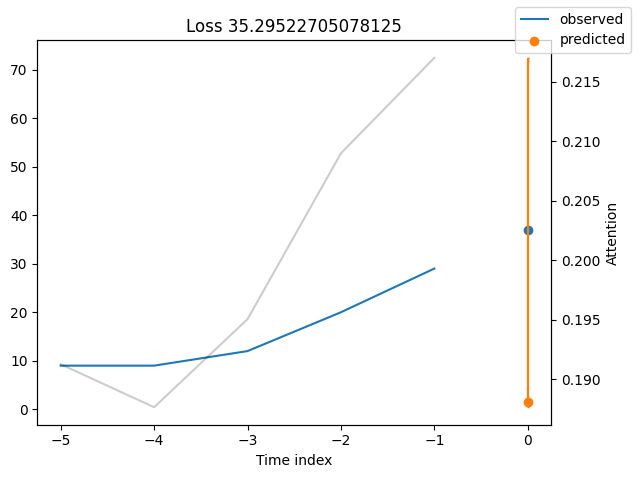

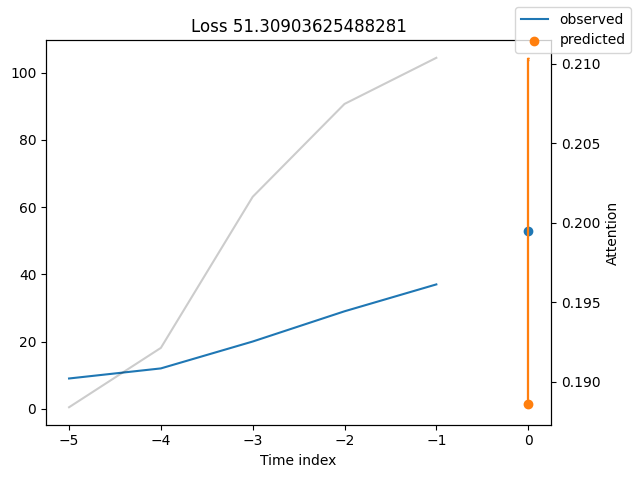

In [20]:
for idx in range(2):  # plot 10 examples
    model.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )